# Brief analysis of the US consumer price index (CPI) 

## Setup

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import signal

In [2]:
# Get US CPI and fed funds effective rate dfs and set year_month as index
df_cpi = pd.read_csv("../data/US_CPI_M.csv", index_col="year_month", parse_dates=True)
df_fed = pd.read_csv("../data/FED_FUNDS_EFFECTIVE_RATE_M.csv", index_col="year_month", parse_dates=True)

In [3]:
# Append the CPI estimate for April of 2024 to the CPI df
df_cpi.loc[pd.to_datetime("2024-04")] = {"rate": 3.4}

In [4]:
# Set charts theme
sns.set_theme(style="darkgrid", rc={"grid.alpha": 0.33})
plt.style.use("dark_background")

# Save chart as png function
def save_chart_as_png(filename: str) -> None:
    plt.savefig(
        f"../images/{filename}.png",
        format="png",
        dpi=300,
        orientation="landscape",
        bbox_inches="tight",
    )

## Datasets basic info

### US consumer price index (CPI)

In [5]:
# First and last entries
pd.concat([df_cpi.head(1), df_cpi.tail(1)]).T

year_month,1956-01-01,2024-04-01
rate,0.374532,3.4


In [6]:
df_cpi.describe().T

,count,mean,std,min,25%,50%,75%,max
rate,820.0,3.675305,2.779924,-2.097161,1.753234,2.985075,4.589179,14.756447


### Federal Reserve funds effective rate

In [7]:
# First and last entries
pd.concat([df_fed.head(1), df_fed.tail(1)]).T

year_month,1954-07-01,2024-04-01
rate,0.8,5.33


In [8]:
df_fed.describe().T

,count,mean,std,min,25%,50%,75%,max
rate,838.0,4.605143,3.584196,0.05,1.8125,4.225,6.23,19.1


## CPI long-term analysis

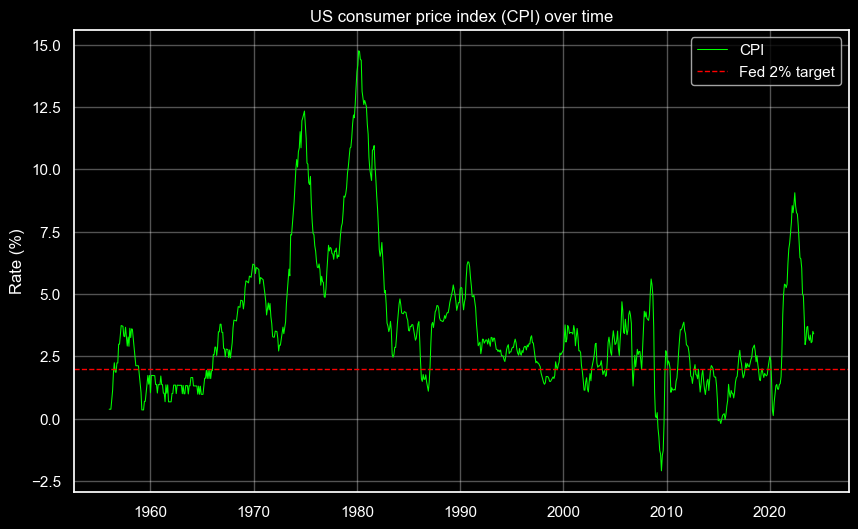

In [9]:
plt.figure(figsize=(10, 6))

sns.lineplot(data=df_cpi, x=df_cpi.index, y="rate", label="CPI", color="lime", linewidth=0.75)
plt.axhline(y=2, label="Fed 2% target", color="red", linewidth=1, linestyle="--")

plt.title("US consumer price index (CPI) over time")
plt.xlabel("")
plt.ylabel("Rate (%)")
plt.legend()

save_chart_as_png("2_US_CPI")

In [10]:
# All-time high
ath_ym = df_cpi["rate"].idxmax().strftime("%Y-%m")
df_cpi.loc[ath_ym]

,rate
year_month,
1980-03-01,14.756447


In [11]:
# All-time low
atl_ym = df_cpi["rate"].idxmin().strftime("%Y-%m")
df_cpi.loc[atl_ym]

,rate
year_month,
2009-07-01,-2.097161


In [12]:
# Highest 6 peaks
peaks, _ = signal.find_peaks(df_cpi["rate"], distance=36)
df_cpi.iloc[peaks].nlargest(6, "rate").sort_values("year_month").T

year_month,1969-12-01,1974-12-01,1980-03-01,1990-10-01,2008-07-01,2022-06-01
rate,6.197183,12.337662,14.756447,6.289809,5.600123,9.059758


In [13]:
# Lowest 6 valleys
valleys, _ = signal.find_peaks(-df_cpi["rate"], distance=36)
df_cpi.iloc[valleys].nsmallest(6, "rate").sort_values("year_month").T

year_month,1959-04-01,1965-01-01,2002-06-01,2009-07-01,2015-04-01,2020-05-01
rate,0.346021,0.970874,1.067416,-2.097161,-0.199517,0.117926


In [14]:
# Get deflationary periods table
# Get negative rates df
df_cpi_def = df_cpi.loc[df_cpi["rate"] < 0].copy()
# Get periods of consecutive dates
df_cpi_def["period"] = (df_cpi_def.index.diff().days > 31).cumsum() + 1
# Get begin, end and avg rate of each period into another df
df_cpi_def.groupby("period").agg(
    begin_date=("rate", lambda x: x.index.min()),
    end_date=("rate", lambda x: x.index.max()),
    average_rate=("rate", "mean")
)

,begin_date,end_date,average_rate
period,,,
1,2009-03-01,2009-10-01,-1.109902
2,2015-01-01,2015-05-01,-0.085513
3,2015-09-01,2015-09-01,-0.036130


In [15]:
# Get longest 5 periods (and respective avg rate) in which the rate was closest to the 2% target (with a 1 percentage point deviation margin)
# Get df with rates close to 2%
df_cpi_close_to_2 = df_cpi[df_cpi["rate"].sub(2).abs().lt(1)].copy()
# Get periods of consecutive dates
df_cpi_close_to_2["period"] = (df_cpi_close_to_2.index.diff().days > 31).cumsum() + 1
# Get begin, end and avg rate of each period into another df
df_close_to_2_periods = df_cpi_close_to_2.groupby("period").agg(
    begin_date=("rate", lambda x: x.index.min()),
    end_date=("rate", lambda x: x.index.max()),
    average_rate=("rate", "mean")
)
# Get the 5 longest periods
longest_periods = df_cpi_close_to_2["period"].value_counts().nlargest(5).index
df_close_to_2_periods.loc[longest_periods]

,begin_date,end_date,average_rate
period,,,
40,2016-08-01,2020-03-01,2.066459
26,1997-03-01,2000-01-01,1.989031
23,1993-06-01,1995-03-01,2.691187
36,2011-12-01,2013-09-01,1.896857
5,1959-08-01,1961-05-01,1.419526


In [16]:
# Get average inflation rate of each decade
df_cpi_dec = df_cpi.groupby((df_cpi.index.year // 10) * 10)
df_cpi_dec = df_cpi_dec["rate"].mean().round(2).reset_index()
df_cpi_dec.columns = ["decade", "avg_cpi"]
df_cpi_dec.set_index("decade").T

decade,1950,1960,1970,1980,1990,2000,2010,2020
avg_cpi,2.15,2.33,7.09,5.56,3.0,2.57,1.77,4.42


**Key takeaways:**
- Inflation surged through the late 1960s, peaking at a historic high of 14.8% in 1980, before rapidly declining.
- During the early 1960s, CPI remained consistently below the 2% target, a level once considered a ceiling by the central bank.
- Throughout 1970s and early 1980s, inflation rates soared significantly, posing economic challenges.
- Throughout the 1990s and between the 2010s and the end of the pandemic lockdowns, inflation remained relatively contained.
- The 2010s marked the decade with the lowest average CPI rate, settling at 1.8%.
- Instances of deflation occurred only in 2009 and 2015.
- Recently, inflation has reemerged as a notable concern.

## CPI + fed rates since 2020 analysis

In [17]:
# Get dfs since 2020
df_cpi_2020 = df_cpi["2020":].copy()
df_fed_2020 = df_fed["2020":].copy()

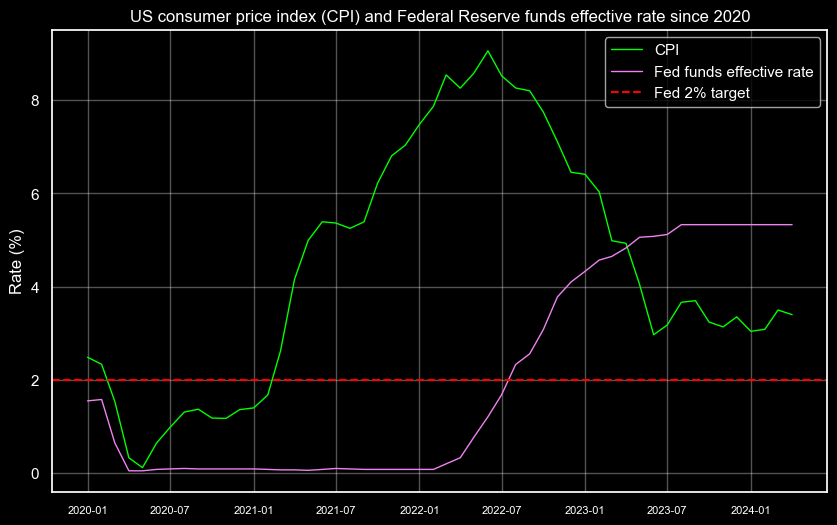

In [18]:
plt.figure(figsize=(10, 6))

sns.lineplot(data=df_cpi_2020, x=df_cpi_2020.index, y="rate", label="CPI", color="lime", linewidth=1)
sns.lineplot(data=df_fed_2020, x=df_fed_2020.index, y="rate", label="Fed funds effective rate", color="violet", linewidth=1)
plt.axhline(y=2, label="Fed 2% target", color="red", linewidth=1.5, linestyle="--")

plt.xticks(fontsize=8)

plt.title("US consumer price index (CPI) and Federal Reserve funds effective rate since 2020")
plt.xlabel("")
plt.ylabel("Rate (%)")
plt.legend()

save_chart_as_png("2_US_CPI_2020")

In [19]:
# When inflation quickly began to rise
cpi_rise_start = df_cpi_2020.loc[df_cpi_2020["rate"].diff() > 0.8].index[0].strftime("%Y-%m")
df_cpi_2020.loc[cpi_rise_start].round(2)

,rate
year_month,
2021-03-01,2.62


In [20]:
# When inflation rate peaked
df_cpi_2020.loc[df_cpi_2020["rate"].idxmax().strftime("%Y-%m")]

,rate
year_month,
2022-06-01,9.059758


In [21]:
# When inflation started to become sticky
# Reverse df
df_cpi_2020_rev = df_cpi_2020.iloc[::-1].copy()
# Get its moving std
df_cpi_2020_rev["rate_moving_std"] = df_cpi_2020_rev["rate"].rolling(window=10).std()
# Get that reversed moving std (std of the next year-months) on the original df
df_cpi_2020["reverse_rate_moving_std"] = df_cpi_2020_rev["rate_moving_std"].iloc[::-1].values
# Get when reverse moving std goes above 0.3
cpi_sticky_start = df_cpi_2020[df_cpi_2020["reverse_rate_moving_std"] < 0.3].index[0].strftime("%Y-%m")
df_cpi_2020.loc[cpi_sticky_start][["rate"]]

,rate
year_month,
2023-06-01,2.969178


In [22]:
# Average inflation since started to become sticky
df_cpi[cpi_sticky_start:]["rate"].mean().round(2)

3.3

In [23]:
# When the fed rate hikes started
fed_rise_start = df_fed_2020.loc[df_fed_2020["rate"].diff() > 0.1].index[0].strftime("%Y-%m")
df_fed_2020.loc[fed_rise_start]

,rate
year_month,
2022-03-01,0.2


In [24]:
# When the fed big rate hikes started
fed_big_rise_start = df_fed_2020.loc[df_fed_2020["rate"].diff() > 0.4].index[0].strftime("%Y-%m")
df_fed_2020.loc[fed_big_rise_start]

,rate
year_month,
2022-05-01,0.77


In [25]:
# When fed rate peaked
df_fed_2020.loc[df_fed_2020["rate"].idxmax().strftime("%Y-%m")]

,rate
year_month,
2023-08-01,5.33


In [26]:
# Average difference between rates since inflation started to become sticky
(df_fed[cpi_sticky_start:]["rate"].mean() - df_cpi[cpi_sticky_start:]["rate"].mean()).round(2)

1.99

**Key takeaways:**
- In March 2021, the CPI breached 2%, quickly escalating to 4.16% the following month, culminating at about 9% by June 2022.
- The Federal Reserve took about a year from the initial inflationary pressure to start the rate hikes, when inflation was no longer perceived as transitory.
- Initially, the Fed's rate adjustments were gradual, beginning in March 2022, but gained momentum by May, reaching a peak in August 2023 before stabilizing.
- Inflation decreased until June 2023, stabilizing at approximately 3.3%, still above the 2% target, and has remained "sticky" at this level.
- During this "sticky" period, there was an average gap of about 2 percentage points between the Fed's interest rates and the CPI rate.